<a href="https://colab.research.google.com/github/Steriva/PINNs-pyTorch/blob/master/PINN_pyTorch_inference_Transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Network for a Transport Equation
In this notebook, we illustrate physics informed neural networks (PINNs) to solve partial differential equations (PDEs) as proposed in

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs and https://github.com/jayroxis/PINNs

The differential problem studied is the Transport equation ($c\in\mathbb{R}$):
\begin{equation}
\left\{
\begin{array}{ll}
\partial_t u + c \partial_x u = 0 &  (t,x) \in (0,2] \times (-3,3)\\
u(0,x) = u_0(x) = \cos^4(\pi \, x)\cdot \mathcal{H}(0.5-|x|) & x \in [-3,3]\\
u(t,-3) = 0  & t \in (0,2]
\end{array}
\right.
\end{equation}
At first, the problem will be solved using a Lax-Wendroff spatial discretisation coupled with implicit Euler for time. This scheme is known to be not fully correct, since the numerical solution will have a delay with respect to the true solution.

This problem has also analytical solution:
\begin{equation}
u_{ex}(x,t) = u_0(x-c\cdot t)
\end{equation}


In [ ]:
!pip install pyDOE

In [94]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse import linalg as spLA
from tqdm.auto import tqdm
np.random.seed(1234)

# Transport velocity
c = 1.

# Definition of the domain
L = 3
T = 2

Nh = 600
Nt = 1000

# Definition of the BC and IC
u0  = lambda x: (np.cos(np.pi * x))**4 * np.heaviside(0.5-np.abs(x), 1.)
fun = lambda x: 0.0 * x
inflow = lambda t: 0.0 * t

# Exact solution
def exact(x, t, c=c):
  return u0(x - c * t)

def implicitEulerSolve(L, Nh, T, Nt, c, inflow, fun, u0):
  dx = 2 * L / Nh
  dt = T / Nt

  CFL = c * dt / dx

  t = np.arange(0,  T+dt, dt)
  x = np.arange(-L, L+dx, dx)
  
  u = np.zeros((Nt+1, Nh+1))
  u[0, :] = u0(x)

  # Assembling matrix A
  e = np.array([- (CFL + CFL**2) / 2 * np.ones((Nh-1)), (1+CFL**2) * np.ones((Nh-1)), (CFL - CFL**2) / 2 * np.ones((Nh-1))])
  A = spdiags(e, np.array([-1, 0, 1]), Nh, Nh)
  A = A.toarray()
  A[-1,-1] = 1 + CFL
  A[-1,-2] = -CFL

  for kk in tqdm(range(Nt)):
    F = fun(x)
    F = dt * F[1:] + u[kk, 1:]
    F[0] += CFL / 2. * inflow(t[kk+1])

    u[kk+1, 0]  = inflow(t[kk+1])
    u[kk+1, 1:] = LA.solve(A,F)

  return x, t, u, CFL

x_true, t_true, u_true, _ = implicitEulerSolve(L, Nh, T, Nt, c, inflow, fun, u0)

  0%|          | 0/1000 [00:00<?, ?it/s]

Now, a different approach is followed in which a Physics-Informed Neural Network will be used.

In [96]:
import torch
from collections import OrderedDict

# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Then, the PINN class is defined which is used for training and prediction. The input consists of:
- *X_u*: the time instants for the BC and the points for the IC
- *u*: values of the solution at *X_u*
- *X_f*: points in space-time to compute the residual and the required derivatives
- *layers*: list with the number of neurons per each layer
- *lb, ub*: lower and upper bound for the input (these are vectors of 2 dim, space+time)
- *nu*: viscosity value

In [112]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, c):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.c = c
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )

        # Adam optimizer example
        # self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + self.c * u_x
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(f'Iter {self.iter+0:05} | Loss: {loss.item():.3e} | Loss_u: {loss_u.item():.3e}| Loss_f: {loss_f.item():.3e}')
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

Now the data are prepared to be used as input for the NN training.

In [113]:
from pyDOE import lhs

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

X, T = np.meshgrid(x_true,t_true)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = u_true.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

# IC
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = u_true[0:1,:].T

# BC - left
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = u_true[:,0:1]

X_u_train = np.vstack([xx1, xx2])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

Let us train the NN

In [114]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, c)
  
model.train()

Iter 00100 | Loss: 3.579e-05 | Loss_u: 2.159e-05| Loss_f: 1.420e-05
Iter 00200 | Loss: 3.234e-06 | Loss_u: 2.018e-06| Loss_f: 1.216e-06
Iter 00300 | Loss: 6.848e-07 | Loss_u: 4.546e-07| Loss_f: 2.302e-07
Iter 00400 | Loss: 3.054e-07 | Loss_u: 9.648e-08| Loss_f: 2.089e-07
Iter 00500 | Loss: 7.189e-08 | Loss_u: 2.918e-08| Loss_f: 4.271e-08


Then, let's test the prediction of the PINN solution with respect to a standard numerical solution.

In [115]:
from scipy.interpolate import griddata
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(u_true - U_pred)

Error u: 8.169082e-02


Let us plot the true solution with respect to the PINN prediction.

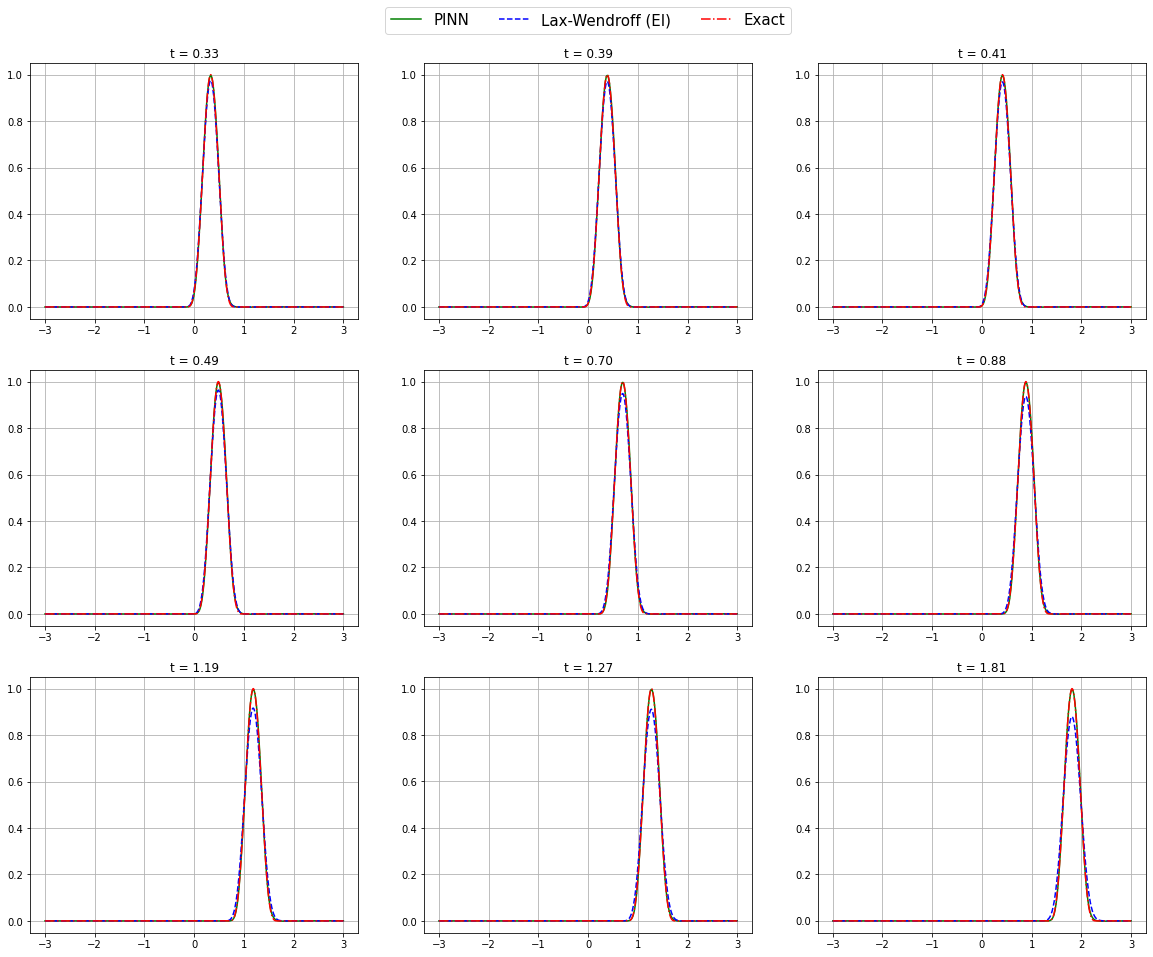

In [122]:
tPlot = np.sort(np.random.choice(range(Nt+1), 9))

LW_vs_TrueFig = plt.figure( figsize = (20,16) )

for ii in range(len(tPlot)):
  plt.subplot(3,3, ii+1)
  plt.plot(x_true, U_pred[tPlot[ii], :], 'g',  label = 'PINN')
  plt.plot(x_true, u_true[tPlot[ii], :], 'b', linestyle='dashed', label = 'Lax-Wendroff (EI)')
  plt.plot(x_true, exact(x_true, t_true[tPlot[ii]]), 'r', linestyle='dashdot', label = 'Exact')
  plt.title('t = {:.2f}'.format(t_true[tPlot[ii]]))
  plt.grid(which='major',linestyle='-')
  plt.grid(which='minor',linestyle='--')

plt.legend(loc='upper center', 
    bbox_to_anchor=(-0.7, 3.65), 
    ncol=3, 
    frameon=True, 
    prop={'size': 15})